In [1]:
import os 
import openai
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.preprocessing import MinMaxScaler
import json 
import re 

## DATA LOADING 

In [2]:
movie_files_path = os.getcwd()+ '\\dataset_review' + '\\2_reviews_per_movie_raw\\'
reviews_dict = {}
for file in os.listdir(movie_files_path):
    movie_name = file.replace('.csv', '')
    movie_name = movie_name.replace('_',':')
    movie_name = movie_name[:-5]
    #read csv document for each movie 
    file_content = pd.read_csv(movie_files_path + file, encoding = "ISO-8859-1").convert_dtypes().to_dict()
    reviews_dict[movie_name] = file_content

In [3]:
movie_reviews_raw = pd.DataFrame.from_dict(reviews_dict,orient='index').convert_dtypes()

In [4]:
movie_reviews_raw['original_title'] = movie_reviews_raw.index
movie_reviews_raw = movie_reviews_raw[['username','rating','helpful','total','date','title','review','original_title']].reset_index().copy()

In [32]:
movie_reviews = movie_reviews_raw[['original_title','username','rating','title', 'review']].copy()

In [33]:
tmdb_5000 =pd.read_csv("C:\\Users\\mihae\\projects\\MoviesProjectCompTools\\dataset_5000\\tmdb_5000_movies.csv")['original_title']

In [34]:
movie_reviews = movie_reviews[movie_reviews['original_title'].isin(list(tmdb_5000))].reset_index()

### FUNCTIONS 

In [6]:
def process_text(dict_review):
    
    new_dict = {}
    for k,text in dict_review.items():
        new_dict[k] = re.sub("<br/>","",text)
    return new_dict 

In [7]:
def replace_username(dict_username, dict_review):

    new_dict = dict((dict_username[key], value) for (key, value) in dict_review.items())
    return new_dict 

### Data Processing 

In [36]:
movie_reviews['review_final'] = movie_reviews.apply(lambda x: process_text(x.review),axis=1)
movie_reviews['review_final'] = movie_reviews.apply(lambda x: replace_username(x.username,x.review_final), axis=1)
movie_reviews['rating_final'] = movie_reviews.apply(lambda x: replace_username(x.username,x.rating), axis=1)
movie_reviews['title_final'] = movie_reviews.apply(lambda x: replace_username(x.username,x.title), axis=1)

In [37]:
movie_reviews['no_reviews'] = movie_reviews['review_final'].apply(lambda x: len(x))

In [38]:
movie_reviews = movie_reviews[['original_title','no_reviews','rating_final','title_final','review_final']]

<AxesSubplot:xlabel='original_title', ylabel='no_reviews'>

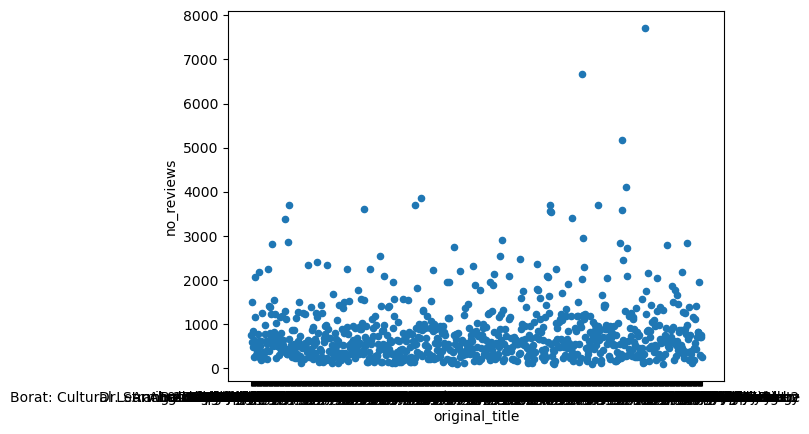

In [39]:
movie_reviews.plot.scatter(x='original_title',y='no_reviews')

### Sentiment Analysis 

In [40]:
from nltk.tokenize import sent_tokenize,word_tokenize, RegexpTokenizer 
from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import itertools
import nltk
from nltk import tokenize 
labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0,lang='english',returnVector=True)

In [25]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 
#using a regex tokenizer because I am cool like that 
tokenizer = RegexpTokenizer(r'\w+')

def get_sent_tokens(some_dict):
    
    lemmatized_dict = {}
    tokens = {}
    
    #lemmatize and set to lower case
    for character in list(some_dict.keys()):
        lemmatized_dict[character] = [lemmatizer.lemmatize(w.lower()) for w in some_dict[character]]
    
    #remove funny characters 
    dialogue_clean = {}
    for character in list(lemmatized_dict.keys()):
        
        clean_txt = []
        for i,sentence in enumerate(lemmatized_dict[character]):
               
            clean_txt.append(re.sub("[^a-zA-Z0-9, \ , \']+","",sentence))
        
       
        dialogue_clean[character] = clean_txt
    
    #tokenize text 
    tokens = {}
    for ch in list(dialogue_clean.keys()):
        
        sent_list = dialogue_clean[ch]
        list_of_tokens = []
        for sent in sent_list:
            list_of_tokens.extend(word_tokenize(sent))
        
        tokens[ch] = list_of_tokens

    return dialogue_clean

In [83]:
def clean_list_helper(lst):

    return [re.sub("[^a-zA-Z0-9, \ , \']+","", list_item) for list_item in lst] 

def tokenize_sent_helper(list): 

    tokenized_lists = [word_tokenize(sent) for sent in list]

    return [val for _list in tokenized_lists for val in _list ]

In [158]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 
#using a regex tokenizer because I am cool like that 
tokenizer = RegexpTokenizer(r'\w+')

def lemmatize_text(some_dict):

    dialogue_lemmatized = {ch:lemmatizer.lemmatize(w.lower()) for ch,w in some_dict.items()}
    
    return dialogue_lemmatized 

def clean_text(dialogue_lemmatized):
    
    #remove funny characters 
    dialogue_clean = {ch:re.sub(r'[^A-Za-z0-9]+', ' ',text)  for ch,text in dialogue_lemmatized.items() }
    
    return dialogue_clean 

def tokenize_dialogue(dialogue_clean):

    
    #tokenize text 
    #dialogue_tokenized = dict ( [(ch, word_tokenize(text)) for ch, text in dialogue_clean.items()] )
    dialogue_tokenized = {ch: word_tokenize(text) for ch, text in dialogue_clean.items()}

    return dialogue_tokenized

def labmt_tokens(dialogue_tokenized):


    reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))
    #reduced_dict = dict(random.choices([*dialogue_tokenized],k=50))
    labmt_tokens = {ch :[float(labMT[token][1]) for token in text if token in list(labMT.keys())] for ch, text in reduced_dict.items()}
    
    return labmt_tokens

In [91]:
d = dict.fromkeys(range(100))

In [42]:
movie_reviews['reviews_lemmatized'] = movie_reviews.apply(lambda x: lemmatize_text(x.review_final),axis=1)

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\1408687755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_reviews['reviews_lemmatized'] = movie_reviews.apply(lambda x: lemmatize_text(x.review_final),axis=1)


In [43]:
movie_reviews['reviews_lemmatized_clean'] =  movie_reviews.apply(lambda x: clean_text(x.reviews_lemmatized),axis=1)

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\3658745749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_reviews['reviews_lemmatized_clean'] =  movie_reviews.apply(lambda x: clean_text(x.reviews_lemmatized),axis=1)


In [ ]:
movie_reviews['tokenized_reviews'] = movie_reviews.apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [88]:
df_1['tokenized_reviews'] = movie_reviews.iloc[:50,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [107]:
df_2['tokenized_reviews']  = movie_reviews.iloc[50:100,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [108]:
df_3['tokenized_reviews']  = movie_reviews.iloc[100:150,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [110]:
df_4['tokenized_reviews'] = movie_reviews.iloc[150:200,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [111]:
df_5['tokenized_reviews'] = movie_reviews.iloc[200:250,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [112]:
df_6['tokenized_reviews'] = movie_reviews.iloc[250:300,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [113]:
df_7['tokenized_reviews'] = movie_reviews.iloc[300:350,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [139]:
df_8['tokenized_reviews'] = movie_reviews.iloc[350:400,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [114]:
df_9['tokenized_reviews'] = movie_reviews.iloc[400:450,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [115]:
df_10['tokenized_reviews'] = movie_reviews.iloc[450:500,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [116]:
df_11['tokenized_reviews'] = movie_reviews.iloc[500:550,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [117]:
df_12['tokenized_reviews'] = movie_reviews.iloc[550:600,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [118]:
df_13['tokenized_reviews'] = movie_reviews.iloc[600:650,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [119]:
df_14['tokenized_reviews'] = movie_reviews.iloc[650:700,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [120]:
df_15['tokenized_reviews'] = movie_reviews.iloc[700:750,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [121]:
df_16['tokenized_reviews'] = movie_reviews.iloc[750:800,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

In [123]:
df_17['tokenized_reviews'] = movie_reviews.iloc[800:822,:].copy().apply(lambda x: tokenize_dialogue(x.reviews_lemmatized_clean),axis=1)

### looking up labmt words 

In [159]:
df_1['labmt_tokens'] = df_1.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [161]:
df_2['labmt_tokens'] = df_2.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [251]:
df_3['labmt_tokens'] = df_3.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [164]:
df_4['labmt_tokens'] = df_4.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [166]:
df_5['labmt_tokens'] = df_5.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [168]:
df_6['labmt_tokens'] = df_6.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [171]:
df_7['labmt_tokens'] = df_7.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [141]:
df_8['labmt_tokens'] = df_8.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\734951925.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [172]:
df_9['labmt_tokens'] = df_9.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [173]:
df_10['labmt_tokens'] = df_10.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [174]:
df_11['labmt_tokens'] = df_11.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [175]:
df_12['labmt_tokens'] = df_12.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [176]:
df_13['labmt_tokens'] = df_13.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [177]:
df_14['labmt_tokens'] = df_14.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [178]:
df_15['labmt_tokens'] = df_15.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [179]:
df_16['labmt_tokens'] = df_16.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [180]:
df_17['labmt_tokens'] = df_17.apply(lambda x: labmt_tokens(x.tokenized_reviews),axis=1)  

C:\Users\mihae\AppData\Local\Temp\ipykernel_8384\502135014.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reduced_dict = dict(random.sample(dialogue_tokenized.items(), 50))


In [186]:
from statistics import mean 

In [256]:
movie_reviews_vs = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12,df_13,df_14,df_15,df_16,df_17])

In [257]:
movie_reviews_vs.to_pickle('movie_reviews_final.pkl')

In [2]:
import pandas as pd 

In [3]:
movie_reviews_vsn = pd.read_pickle('movie_reviews_final.pkl') 

In [5]:
def compute_avg_sent(dict_tokens):

    try:

        avg_sent_per_user = {ch:sum(token_sent)/len(token_sent) for ch,token_sent in dict_tokens.items()}
        return sum(list(avg_sent_per_user.values()))/len(avg_sent_per_user)
        #sum(list(avg_sent_per_user.values()))/len(avg_sent_per_user)

    except:
        "Average score could not be computed. Dictionary empty."

In [6]:
movie_reviews_vsn['average_sentiment'] = movie_reviews_vsn.apply(lambda x: compute_avg_sent(x.labmt_tokens),axis=1)

In [7]:
movie_reviews_vsn['average_sentiment'] = movie_reviews_vsn.apply(lambda x: round(x.average_sentiment,2), axis=1)

In [8]:
movie_reviews_vsn[movie_reviews_vsn["average_sentiment"].isnull()]

,original_title,no_reviews,rating_final,title_final,review_final,reviews_lemmatized,reviews_lemmatized_clean,tokenized_reviews,labmt_tokens,average_sentiment
314,Iron Man 3,1312,"{'ivo-cobra8': '9', 'MR_Heraclius': '8', 'shan...",{'ivo-cobra8': ' A Big improvement over Iron M...,{'ivo-cobra8': 'Iron Man 3 (2013) is A Marvel ...,{'ivo-cobra8': 'iron man 3 (2013) is a marvel ...,{'ivo-cobra8': 'iron man 3 2013 is a marvel pu...,"{'ivo-cobra8': ['iron', 'man', '3', '2013', 'i...","{'Wormholeninefanpage': [6.58, 3.86, 5.24, 6.6...",NaN
350,Little Miss Sunshine,947,"{'imaginarytruths': '8', 'cchase': '9', 'Matth...",{'imaginarytruths': ' a scathing black comedy ...,"{'imaginarytruths': 'I hate to admit it, but m...","{'imaginarytruths': 'i hate to admit it, but m...",{'imaginarytruths': 'i hate to admit it but my...,"{'imaginarytruths': ['i', 'hate', 'to', 'admit...","{'mikek-1': [['2940', '5.92', '1.3377', '2', '...",NaN
351,Live Free or Die Hard,824,"{'ivo-cobra8': '10', 'Rick_Bman': '6', 'dv909'...",{'ivo-cobra8': ' Live Free or Die Hard is the ...,{'ivo-cobra8': 'Live Free or Die Hard (2007) i...,{'ivo-cobra8': 'live free or die hard (2007) i...,{'ivo-cobra8': 'live free or die hard 2007 is ...,"{'ivo-cobra8': ['live', 'free', 'or', 'die', '...","{'Sjhm': [['2940', '5.92', '1.3377', '2', '18'...",NaN
352,"Lock, Stock and Two Smoking Barrels",573,"{'CriticNick': '10', 'doktor d': 'Null', 'Quag...",{'CriticNick': ' Seriously addictive movie - T...,{'CriticNick': 'The first time I saw this movi...,{'CriticNick': 'the first time i saw this movi...,{'CriticNick': 'the first time i saw this movi...,"{'CriticNick': ['the', 'first', 'time', 'i', '...","{'RainDogJr': [['6767', '5.08', '0.9655', '134...",NaN
353,Lone Survivor,491,"{'MR_Heraclius': '9', 'NanoFrog': '8', 'second...","{'MR_Heraclius': ' Great story ', 'NanoFrog':...",{'MR_Heraclius': 'A truly brutal and gripping ...,{'MR_Heraclius': 'a truly brutal and gripping ...,{'MR_Heraclius': 'a truly brutal and gripping ...,"{'MR_Heraclius': ['a', 'truly', 'brutal', 'and...","{'whshoukri': [['2940', '5.92', '1.3377', '2',...",NaN
354,Looper,759,"{'davejones': '7', 'smug2000': '5', 'o1191108'...",{'davejones': ' I wish the writer had finished...,{'davejones': 'Don't get me wrong; this movie ...,{'davejones': 'don't get me wrong; this movie ...,{'davejones': 'don t get me wrong this movie i...,"{'davejones': ['don', 't', 'get', 'me', 'wrong...","{'Tcarts76': [['6339', '5.18', '0.7197', '7', ...",NaN
355,Lord of War,481,"{'jon.h.ochiai': '10', 'jdcorcor': '8', 'leila...","{'jon.h.ochiai': ' Just Evil Prevails ', 'jdc...",{'jon.h.ochiai': 'Atop a hillside in Liberia o...,{'jon.h.ochiai': 'atop a hillside in liberia o...,{'jon.h.ochiai': 'atop a hillside in liberia o...,"{'jon.h.ochiai': ['atop', 'a', 'hillside', 'in...","{'stefannemanja7': [['9814', '3.00', '1.6759',...",NaN
356,Lords of Dogtown,206,"{'jlauro9': '9', 'smurf_is_sxc': '8', 'zephyrf...","{'jlauro9': ' A Great, Under Rated Movie ', '...",{'jlauro9': 'If you listen to a lot of the com...,{'jlauro9': 'if you listen to a lot of the com...,{'jlauro9': 'if you listen to a lot of the com...,"{'jlauro9': ['if', 'you', 'listen', 'to', 'a',...","{'DanielLowery96': [['3211', '5.84', '1.6081',...",NaN
357,Lost in Translation,1962,"{'SECurtisTX': '9', 'jlmmymack-1': '10', 'mlee...","{'SECurtisTX': ' Lost Souls ', 'jlmmymack-1':...",{'SECurtisTX': 'It's been a long time since a ...,{'SECurtisTX': 'it's been a long time since a ...,{'SECurtisTX': 'it s been a long time since a ...,"{'SECurtisTX': ['it', 's', 'been', 'a', 'long'...","{'DeskLazer': [['6929', '5.06', '0.7669', '21'...",NaN
358,Love Actually,1132,"{'milareppa': '9', 'bzb2001': '10', 'claireros...","{'milareppa': ' Surprisingly Enjoyable ', 'bz...",{'milareppa': 'I hate romantic comedies. I det...,{'milareppa': 'i hate romantic comedies. i det...,{'milareppa': 'i hate romantic comedies i dete...,"{'milareppa': ['i', 'hate', 'romantic', 'comed...","{'alex-278': [['8030', '4.80'

In [215]:
type(dict_t['kieranbattams'])

list

In [10]:
movie_reviews_vsn.columns

Index(['original_title', 'no_reviews', 'rating_final', 'title_final',
       'review_final', 'reviews_lemmatized', 'reviews_lemmatized_clean',
       'tokenized_reviews', 'labmt_tokens', 'average_sentiment'],
      dtype='object')

In [13]:
822-51

771

In [11]:
movie_reviews_final = movie_reviews_vsn[['original_title','average_sentiment']]

In [12]:
movie_reviews_final.to_pickle('movie_sentiment.pkl')